In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from path_explain.path_explainer_tf import PathExplainerTF
from path_explain.utils import set_up_environment
from plot.scatter import scatter_plot
from plot.summary import summary_plot

from preprocess import pulsar_dataset

In [3]:
set_up_environment(visible_devices='1')

In [2]:
x_train, y_train, x_test, y_test, feature_names = pulsar_dataset()

In [7]:
y_train.shape

(14318,)

In [6]:
y_train.sum()

1365

In [9]:
y_test.shape

(3580,)

In [10]:
y_test.sum()

274

In [47]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(8,)))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,  activation=None))
model.add(tf.keras.layers.Activation(tf.keras.activations.sigmoid))

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
                                                               decay_steps=1,
                                                               decay_rate=0.96,
                                                               staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.fit(x_train,
          y_train,
          batch_size=256,
          epochs=10,
          verbose=2,
          class_weight={0: 1,
                        1: 3})
train_loss, train_accuracy, train_auc = model.evaluate(x_train, y_train, batch_size=51, verbose=0)
test_loss, test_accuracy, test_auc = model.evaluate(x_test, y_test, batch_size=51, verbose=0)

Train on 14318 samples
Epoch 1/10
14318/14318 - 1s - loss: 0.2314 - binary_accuracy: 0.9651 - auc_14: 0.9542
Epoch 2/10
14318/14318 - 0s - loss: 0.1751 - binary_accuracy: 0.9741 - auc_14: 0.9717
Epoch 3/10
14318/14318 - 0s - loss: 0.1736 - binary_accuracy: 0.9755 - auc_14: 0.9722
Epoch 4/10
14318/14318 - 0s - loss: 0.1734 - binary_accuracy: 0.9755 - auc_14: 0.9724
Epoch 5/10
14318/14318 - 0s - loss: 0.1734 - binary_accuracy: 0.9755 - auc_14: 0.9724
Epoch 6/10
14318/14318 - 0s - loss: 0.1734 - binary_accuracy: 0.9755 - auc_14: 0.9724
Epoch 7/10
14318/14318 - 0s - loss: 0.1734 - binary_accuracy: 0.9755 - auc_14: 0.9724
Epoch 8/10
14318/14318 - 0s - loss: 0.1734 - binary_accuracy: 0.9755 - auc_14: 0.9724
Epoch 9/10
14318/14318 - 0s - loss: 0.1734 - binary_accuracy: 0.9755 - auc_14: 0.9724
Epoch 10/10
14318/14318 - 0s - loss: 0.1734 - binary_accuracy: 0.9755 - auc_14: 0.9724


In [48]:
print('Train loss: {:.4f}\tTrain Accuracy: {:.4f}\tTrain AUC: {:.4f}'.format(train_loss, train_accuracy, train_auc))
print('Test loss: {:.4f}\tTest Accuracy: {:.4f}\tTest AUC: {:.4f}'.format(test_loss, test_accuracy, test_auc))

Train loss: 0.0983	Train Accuracy: 0.9755	Train AUC: 0.9724
Test loss: 0.0900	Test Accuracy: 0.9802	Test AUC: 0.9687


In [49]:
y_pred = model.predict(x_test, batch_size=256)
y_pred_max = (y_pred[:, 0] > 0.5).astype(int)
confusion_matrix(y_test, y_pred_max)

array([[3272,   34],
       [  37,  237]])

In [50]:
explainer = PathExplainerTF(model)

In [4]:
try:
    attributions = np.load('attributions.npy')
except FileNotFoundError:
    attributions = explainer.attributions(inputs=x_test,
                                          baseline=x_train,
                                          batch_size=100,
                                          num_samples=200,
                                          use_expectation=True,
                                          output_indices=0,
                                          verbose=True)
    np.save('attributions.npy', attributions)

In [5]:
try:
    interactions = np.load('interactions.npy')
except FileNotFoundError:
    interactions = explainer.interactions(inputs=x_test,
                                          baseline=x_train,
                                          batch_size=100,
                                          num_samples=200,
                                          use_expectation=True,
                                          output_indices=0,
                                          verbose=True)
    np.save('interactions.npy', interactions)

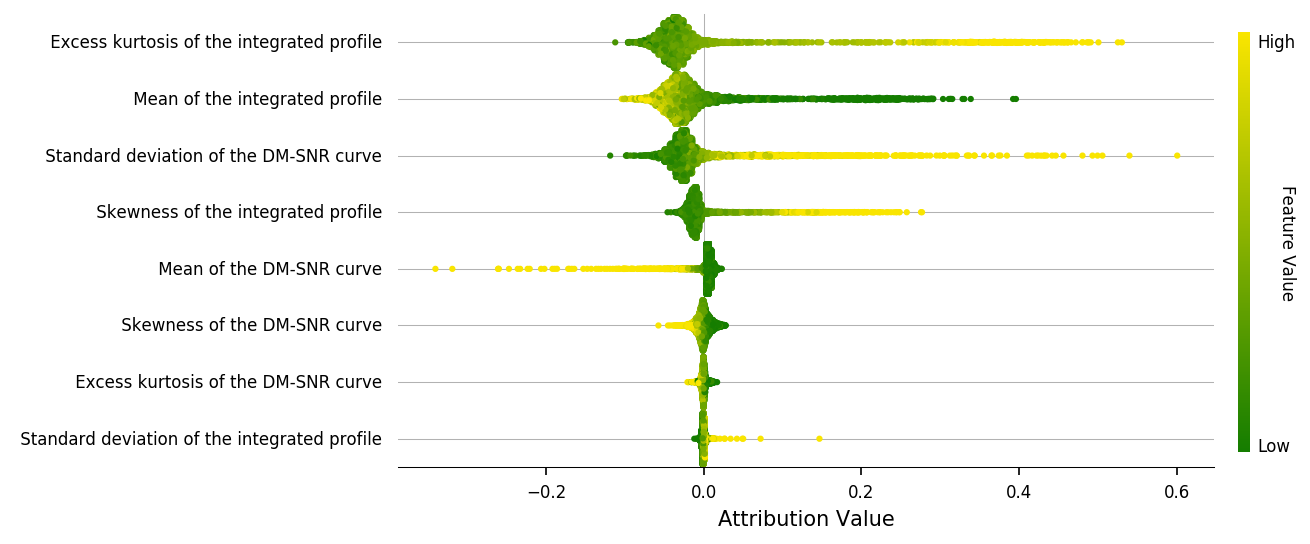

In [6]:
summary_plot(attributions,
             x_test,
             interactions=None,
             interaction_feature=None,
             feature_names=feature_names,
             plot_top_k=None)

In [7]:
mean_abs_interactions = np.mean(np.abs(interactions), axis=0)

In [8]:
feature_names[5]

' Standard deviation of the DM-SNR curve'

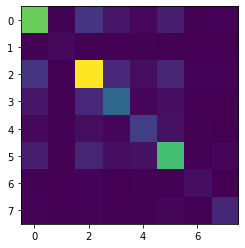

In [9]:
plt.imshow(mean_abs_interactions)

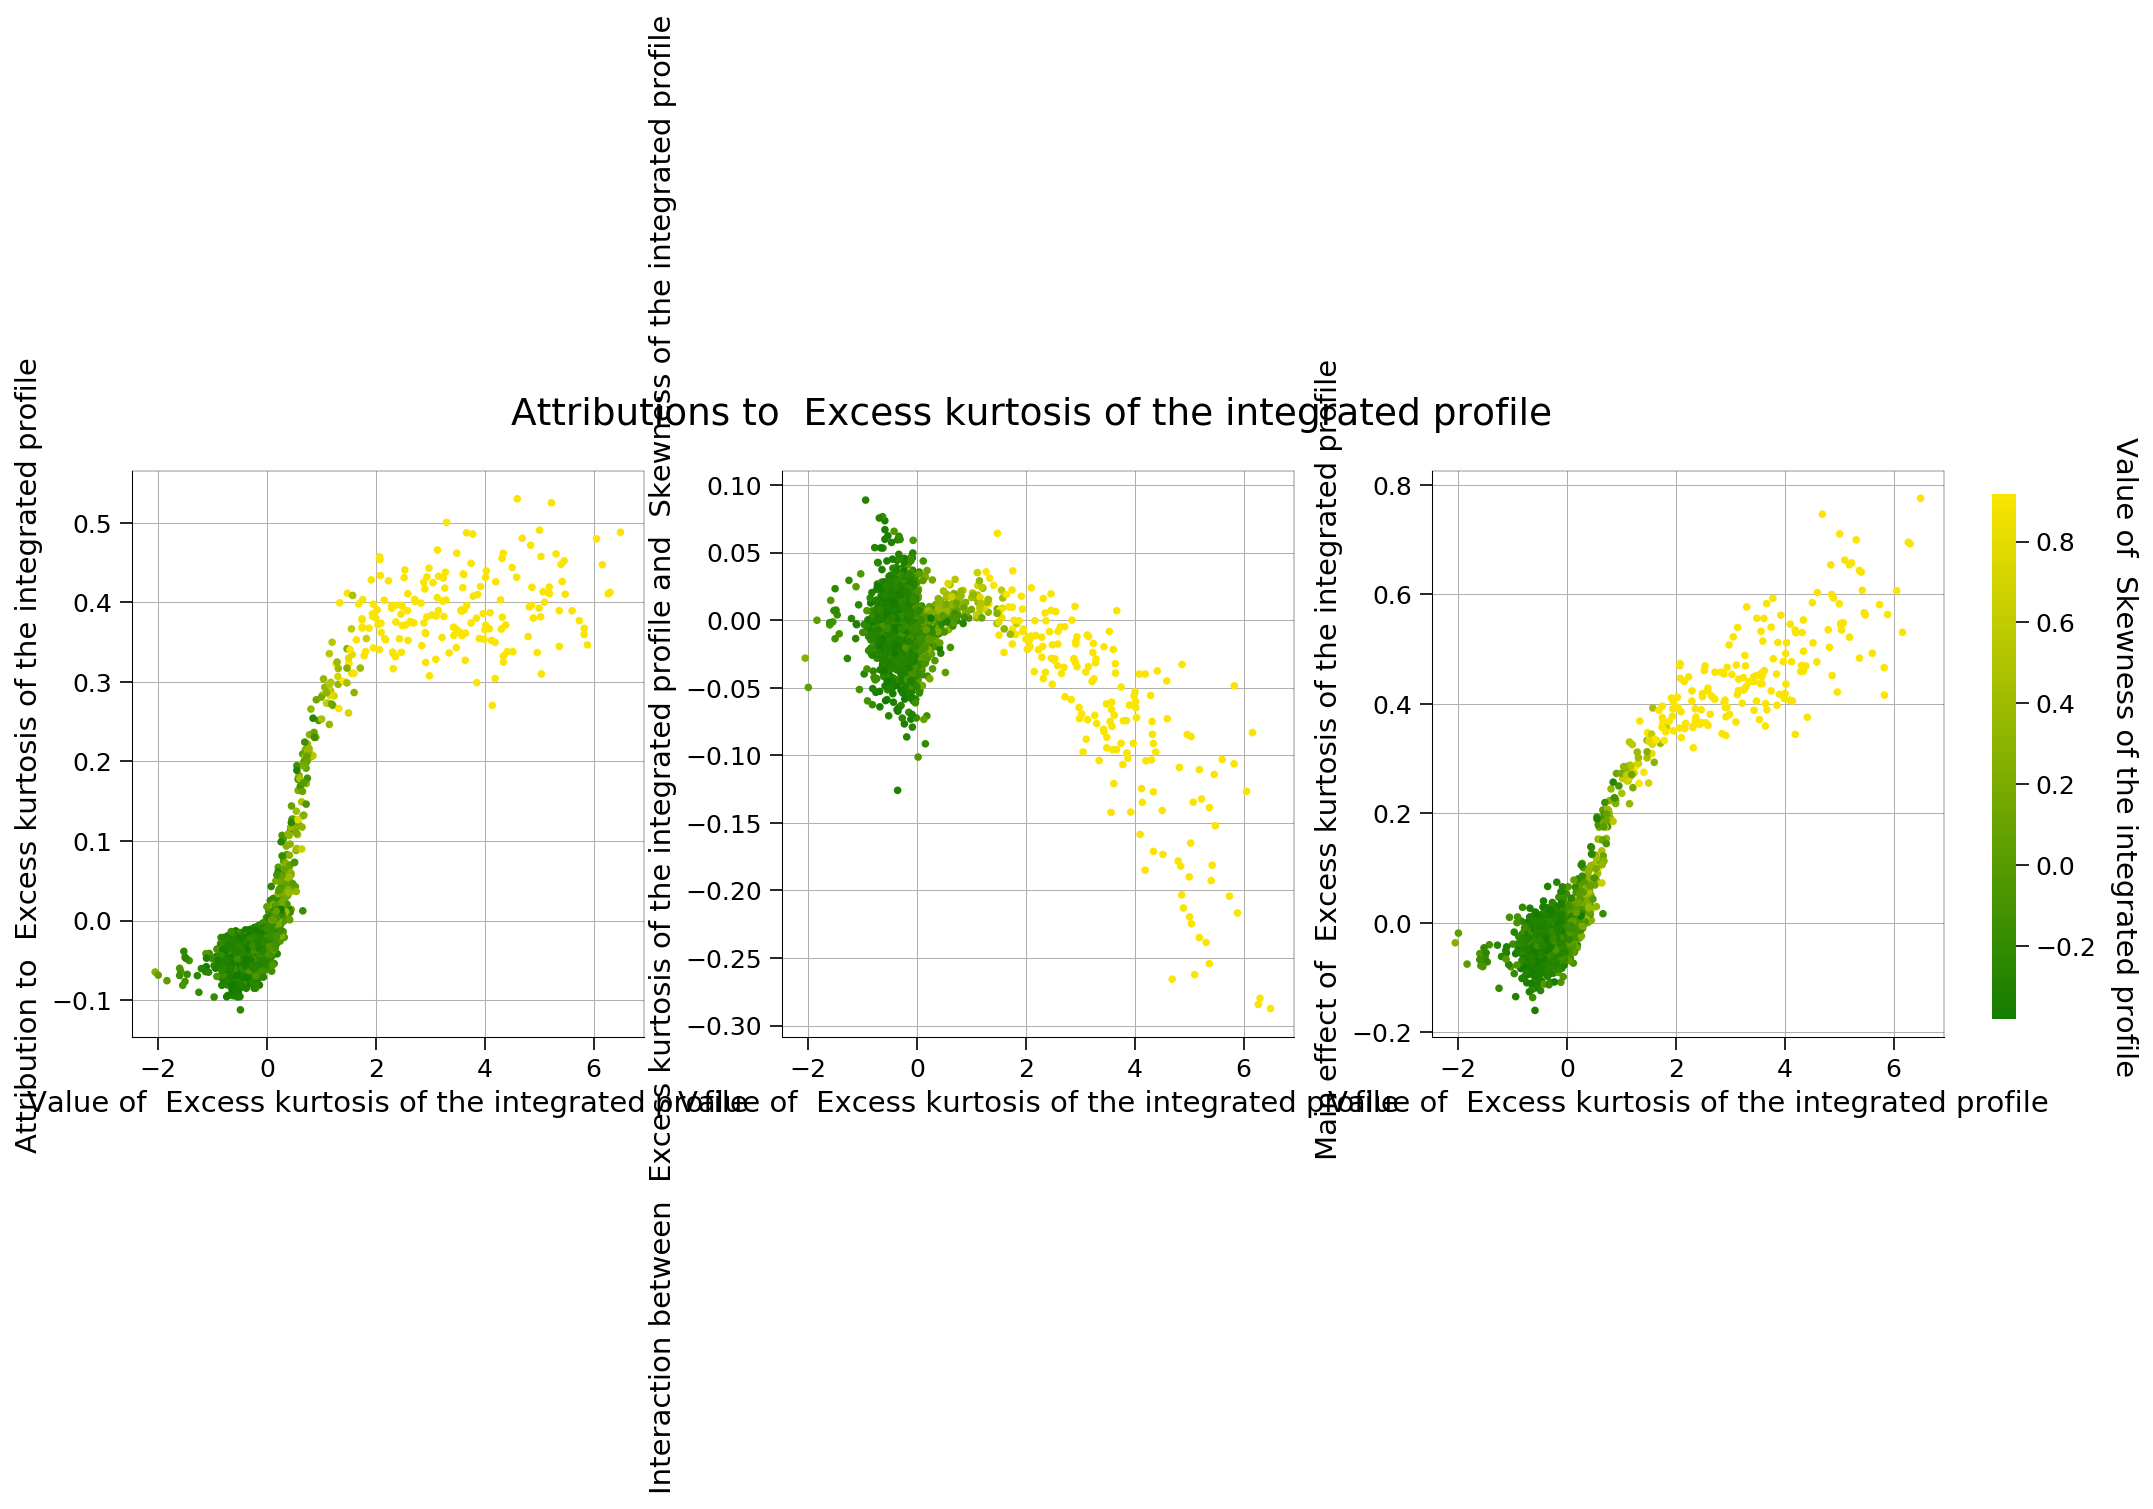

In [10]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index=' Excess kurtosis of the integrated profile',
                        interactions=interactions,
                        color_by=' Skewness of the integrated profile',
                        feature_names=feature_names,
                        scale_y_ind=True)

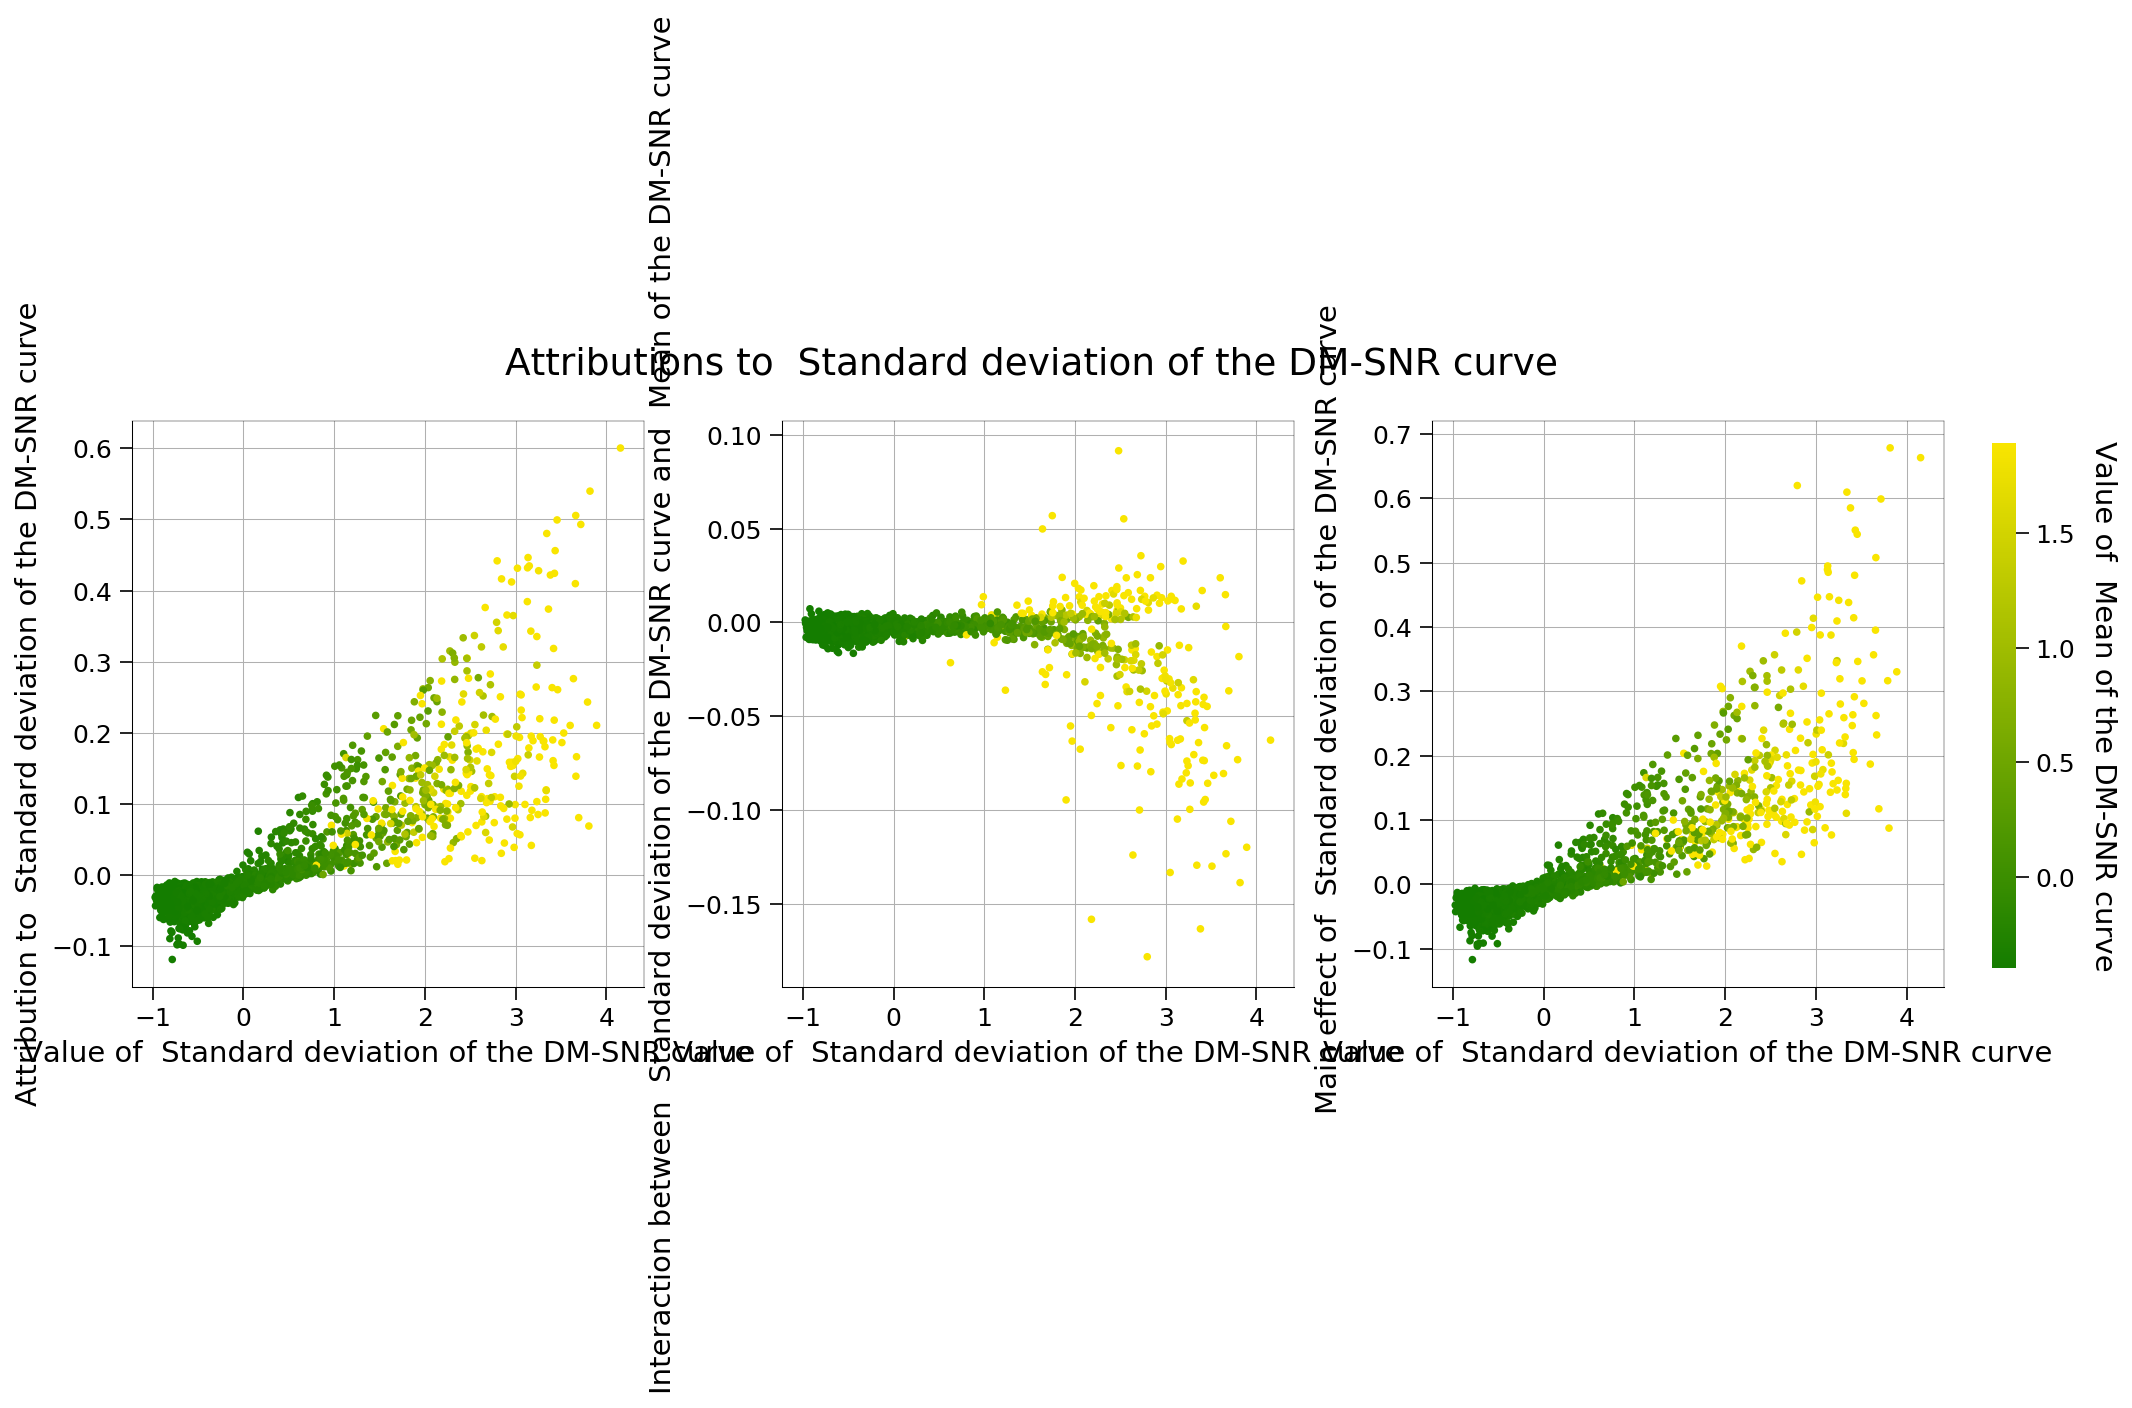

In [11]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index=' Standard deviation of the DM-SNR curve',
                        interactions=interactions,
                        color_by=' Mean of the DM-SNR curve',
                        feature_names=feature_names,
                        scale_y_ind=True)

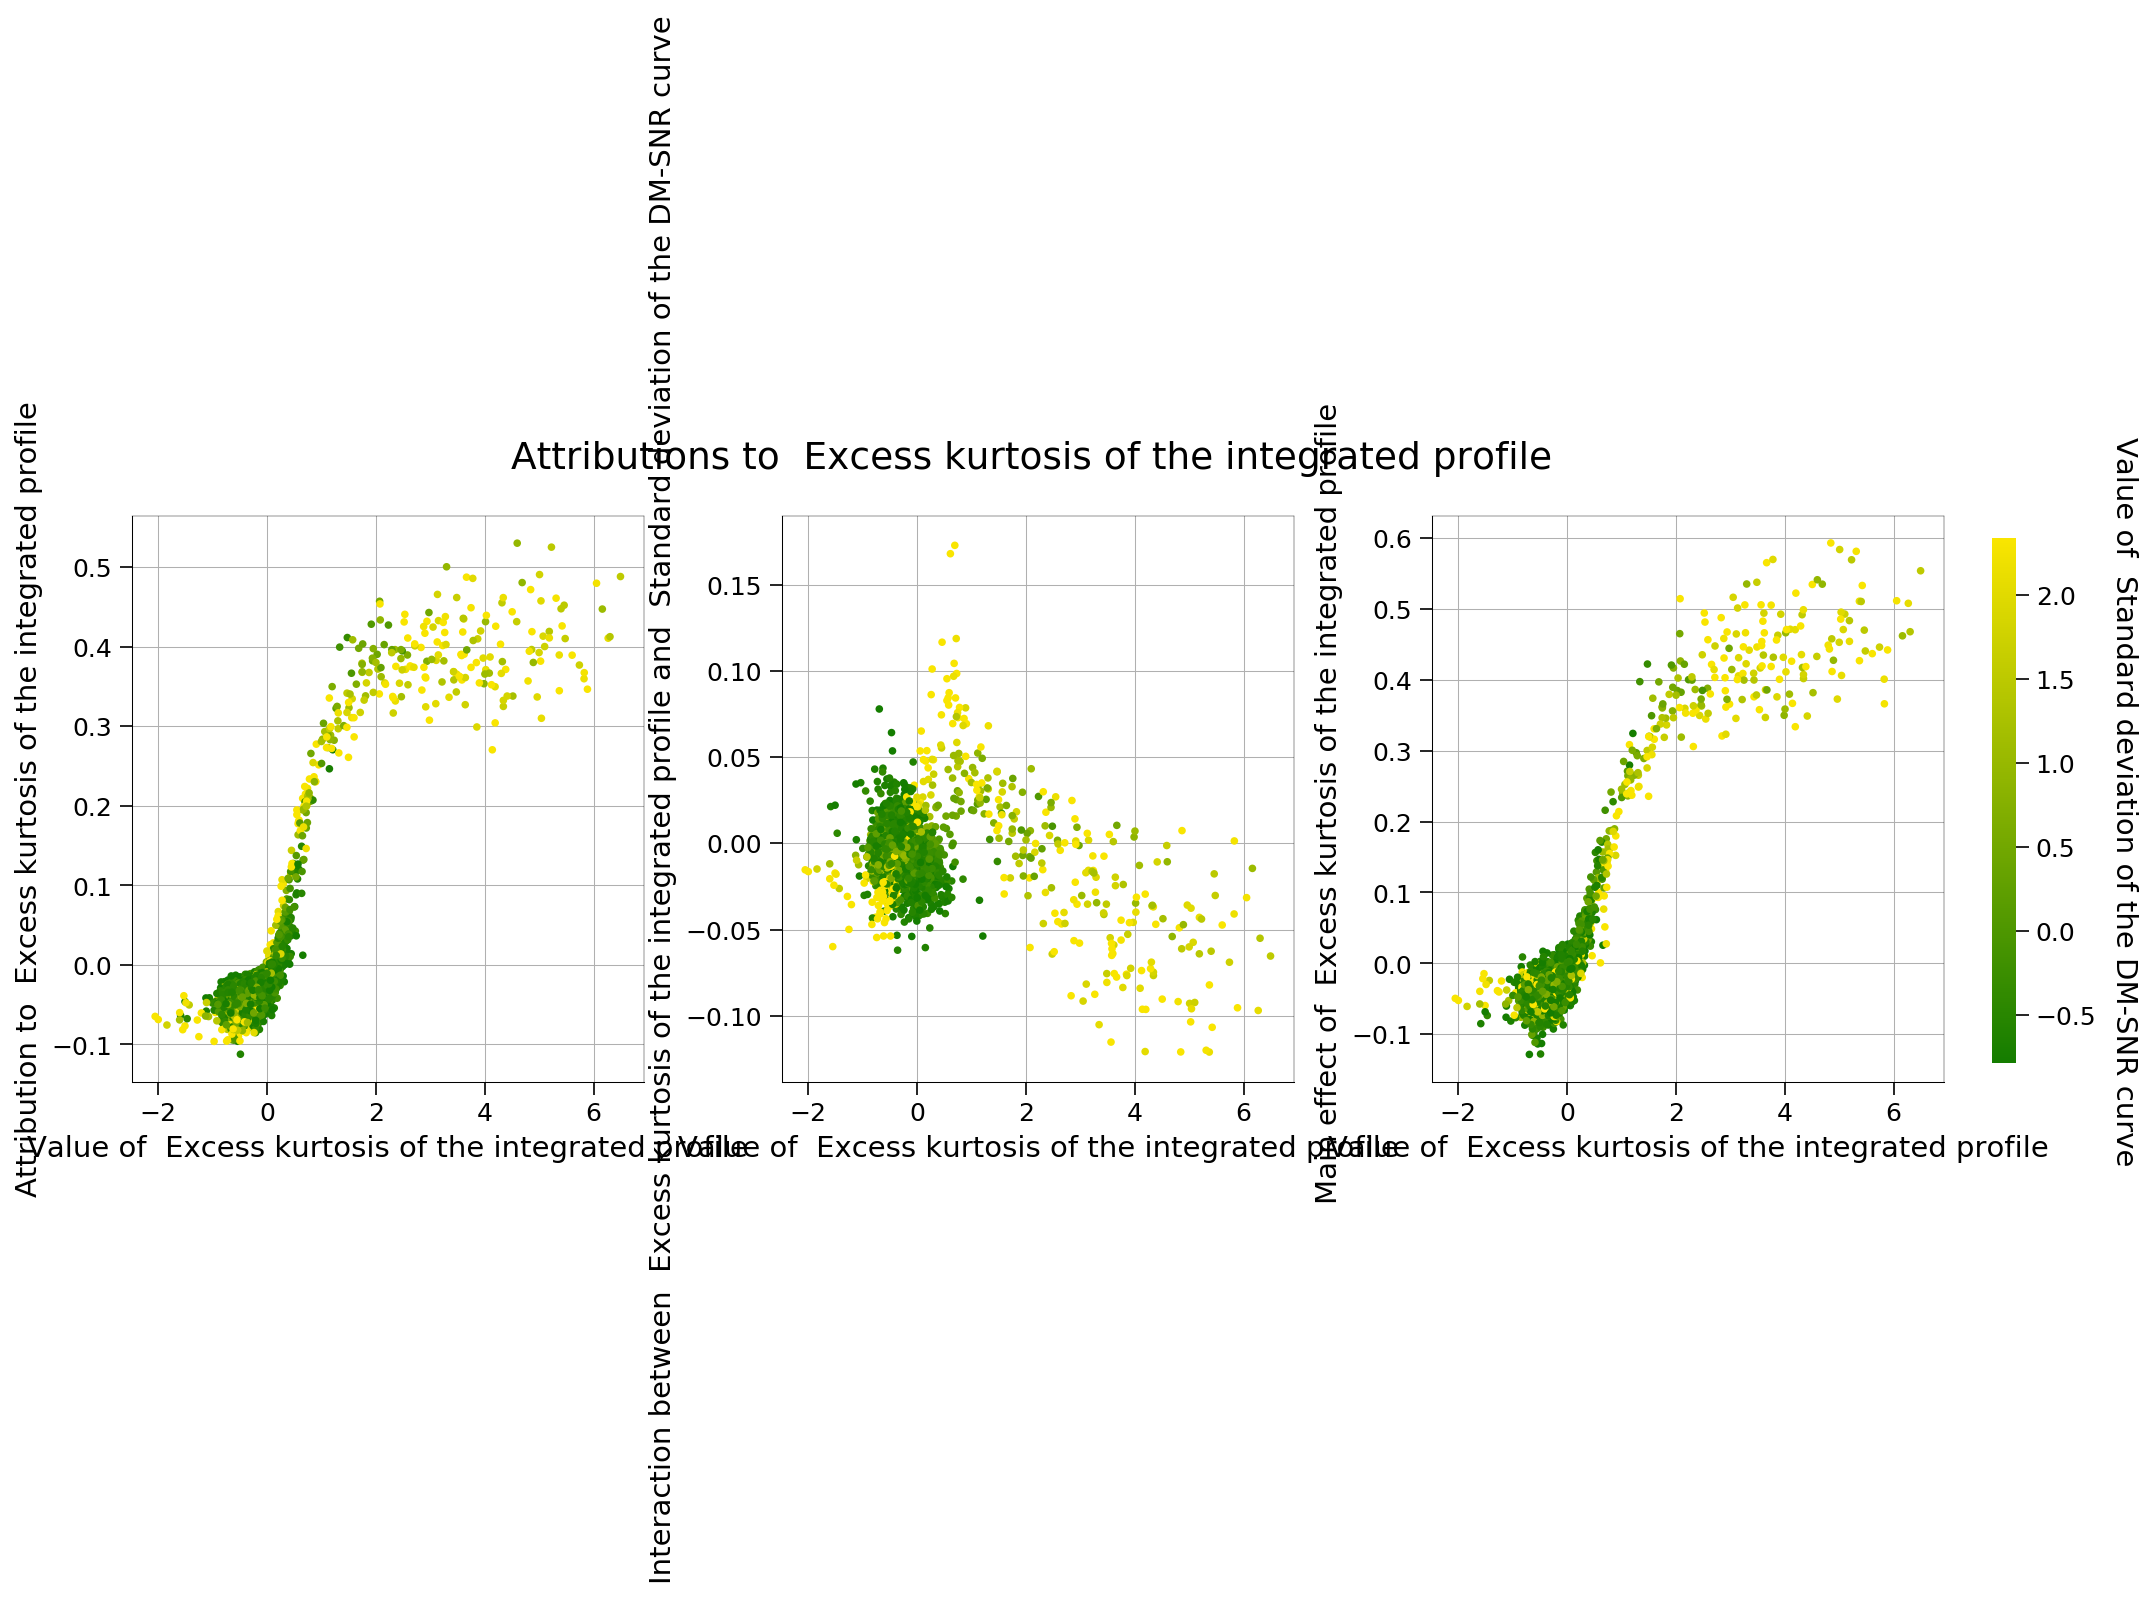

In [12]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index=' Excess kurtosis of the integrated profile',
                        interactions=interactions,
                        color_by=' Standard deviation of the DM-SNR curve',
                        feature_names=feature_names,
                        scale_y_ind=True)

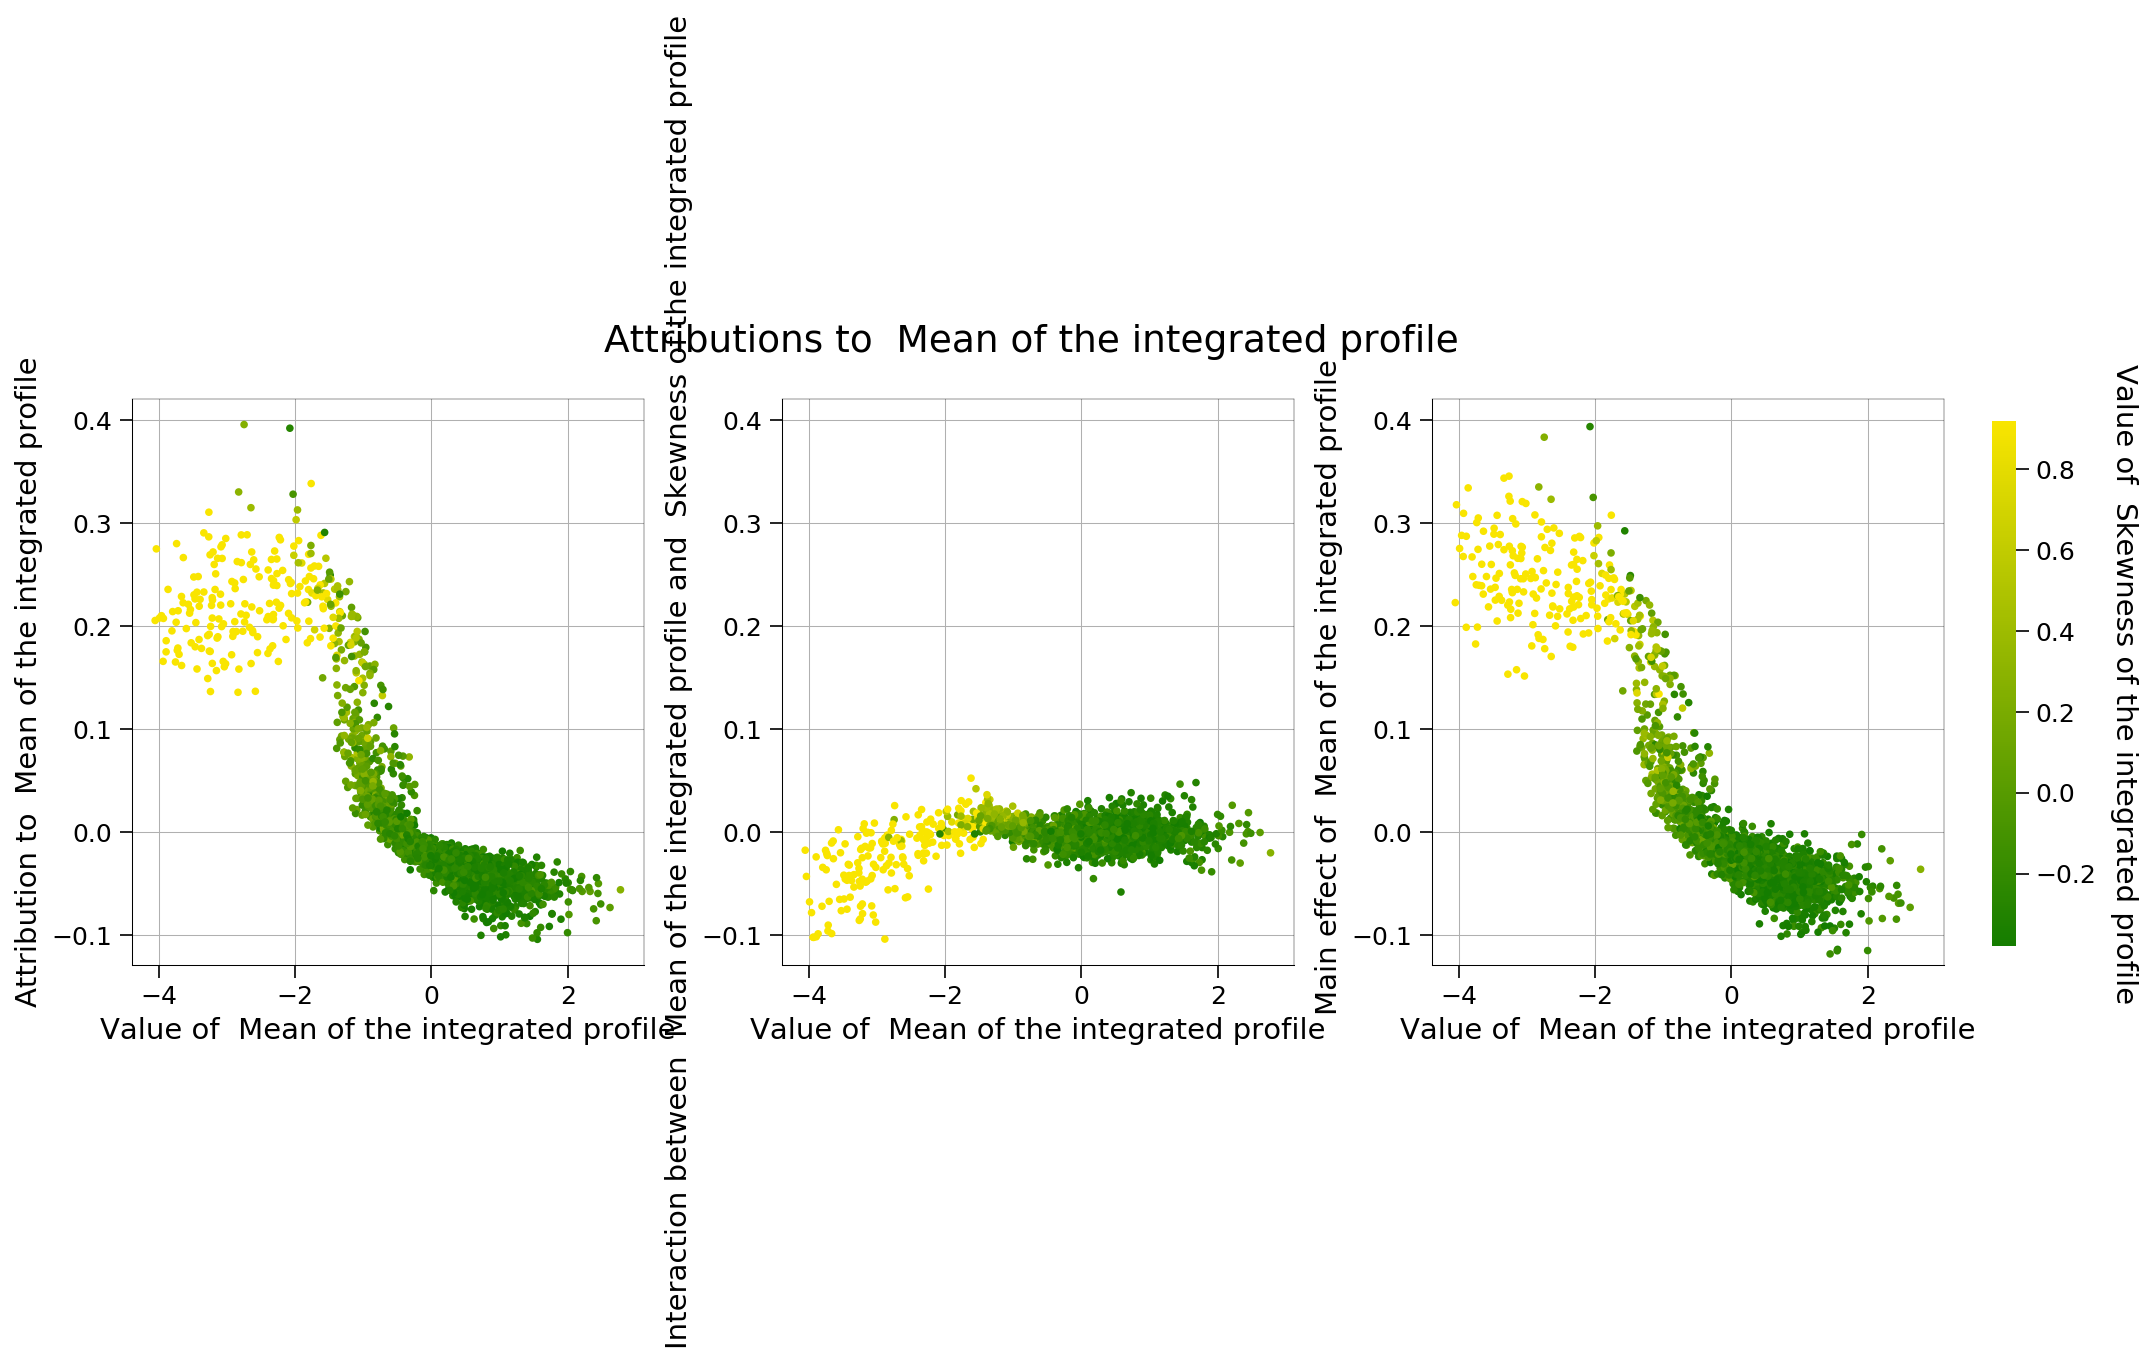

In [13]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index=' Mean of the integrated profile',
                        interactions=interactions,
                        color_by=' Skewness of the integrated profile',
                        feature_names=feature_names)

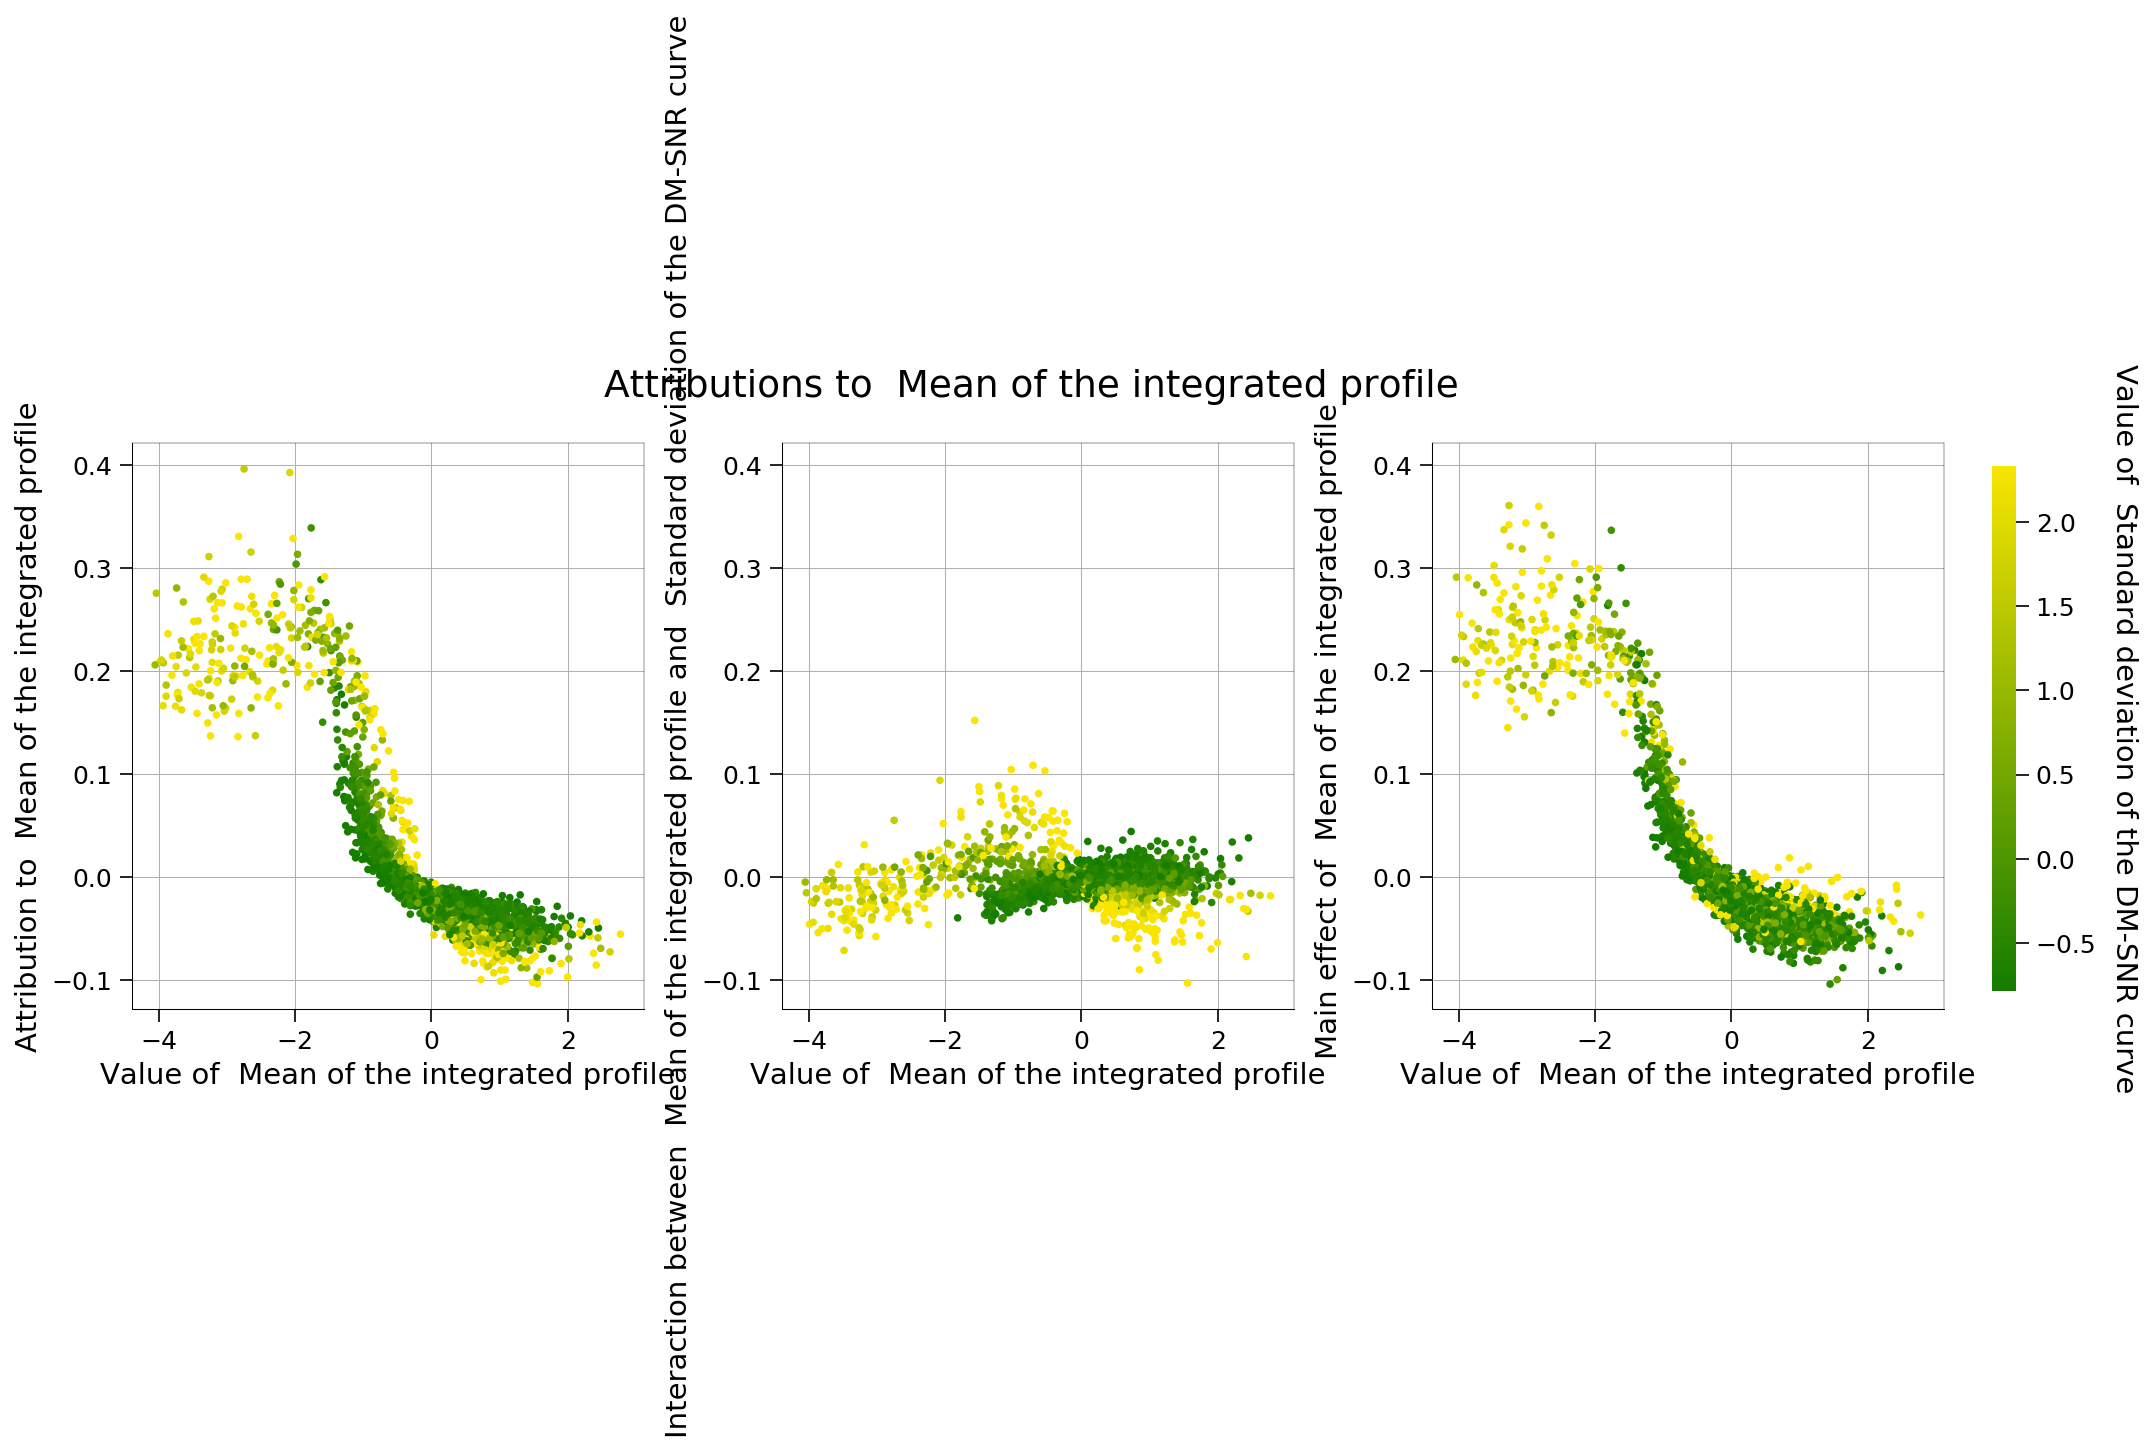

In [14]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index=' Mean of the integrated profile',
                        interactions=interactions,
                        color_by=' Standard deviation of the DM-SNR curve',
                        feature_names=feature_names)

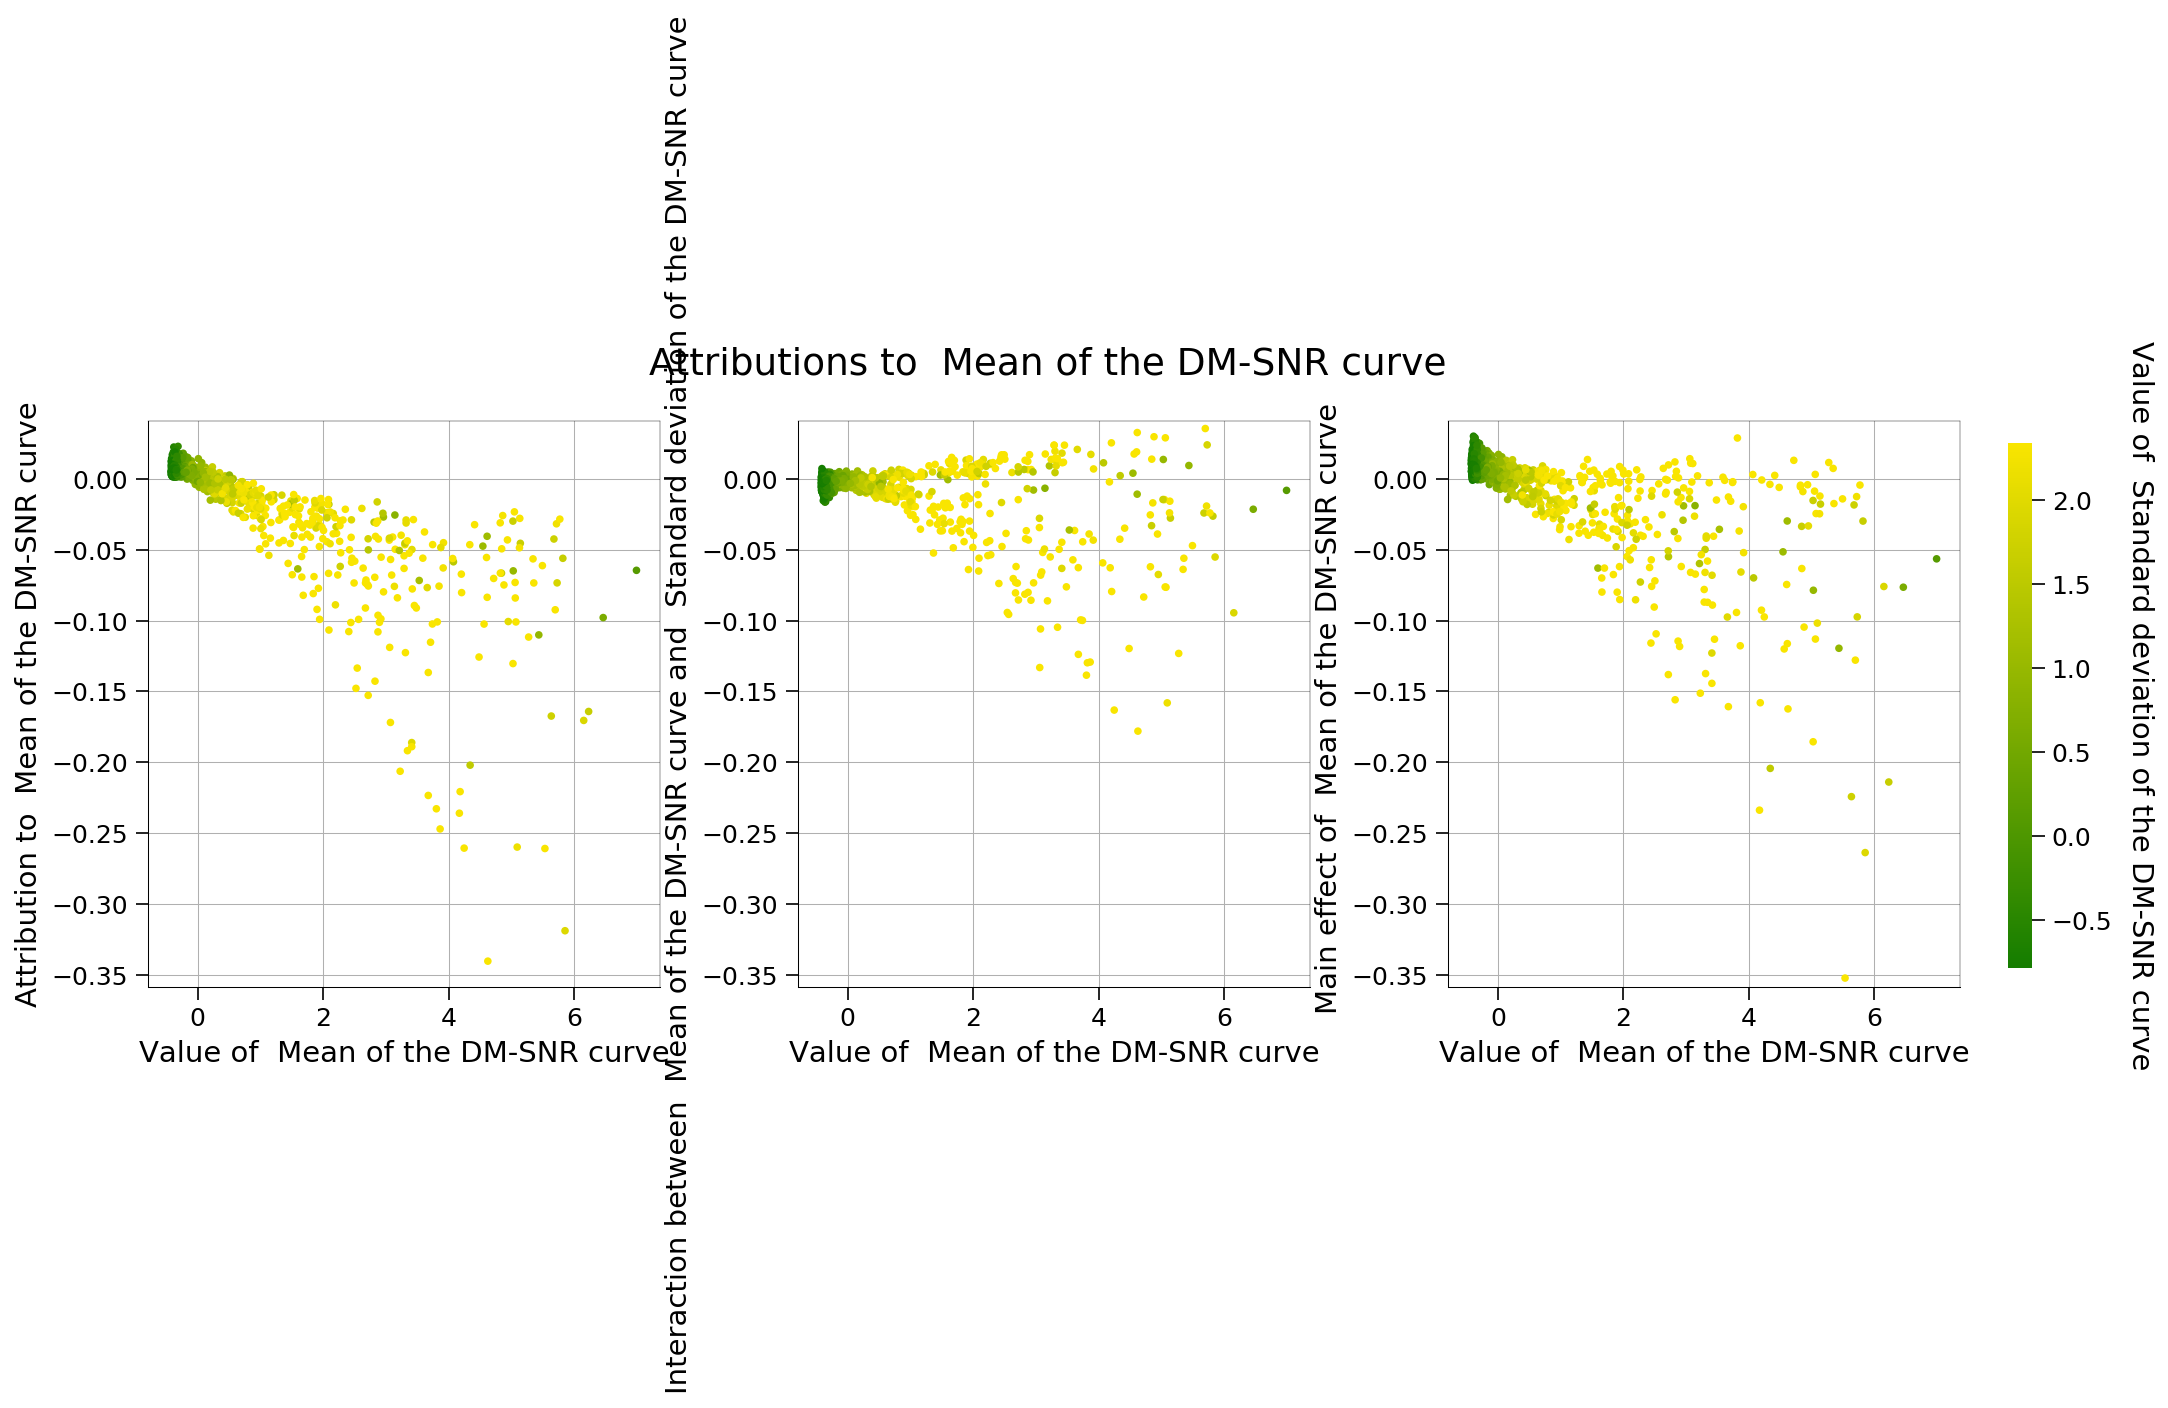

In [15]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index=' Mean of the DM-SNR curve',
                        interactions=interactions,
                        color_by=' Standard deviation of the DM-SNR curve',
                        feature_names=feature_names)

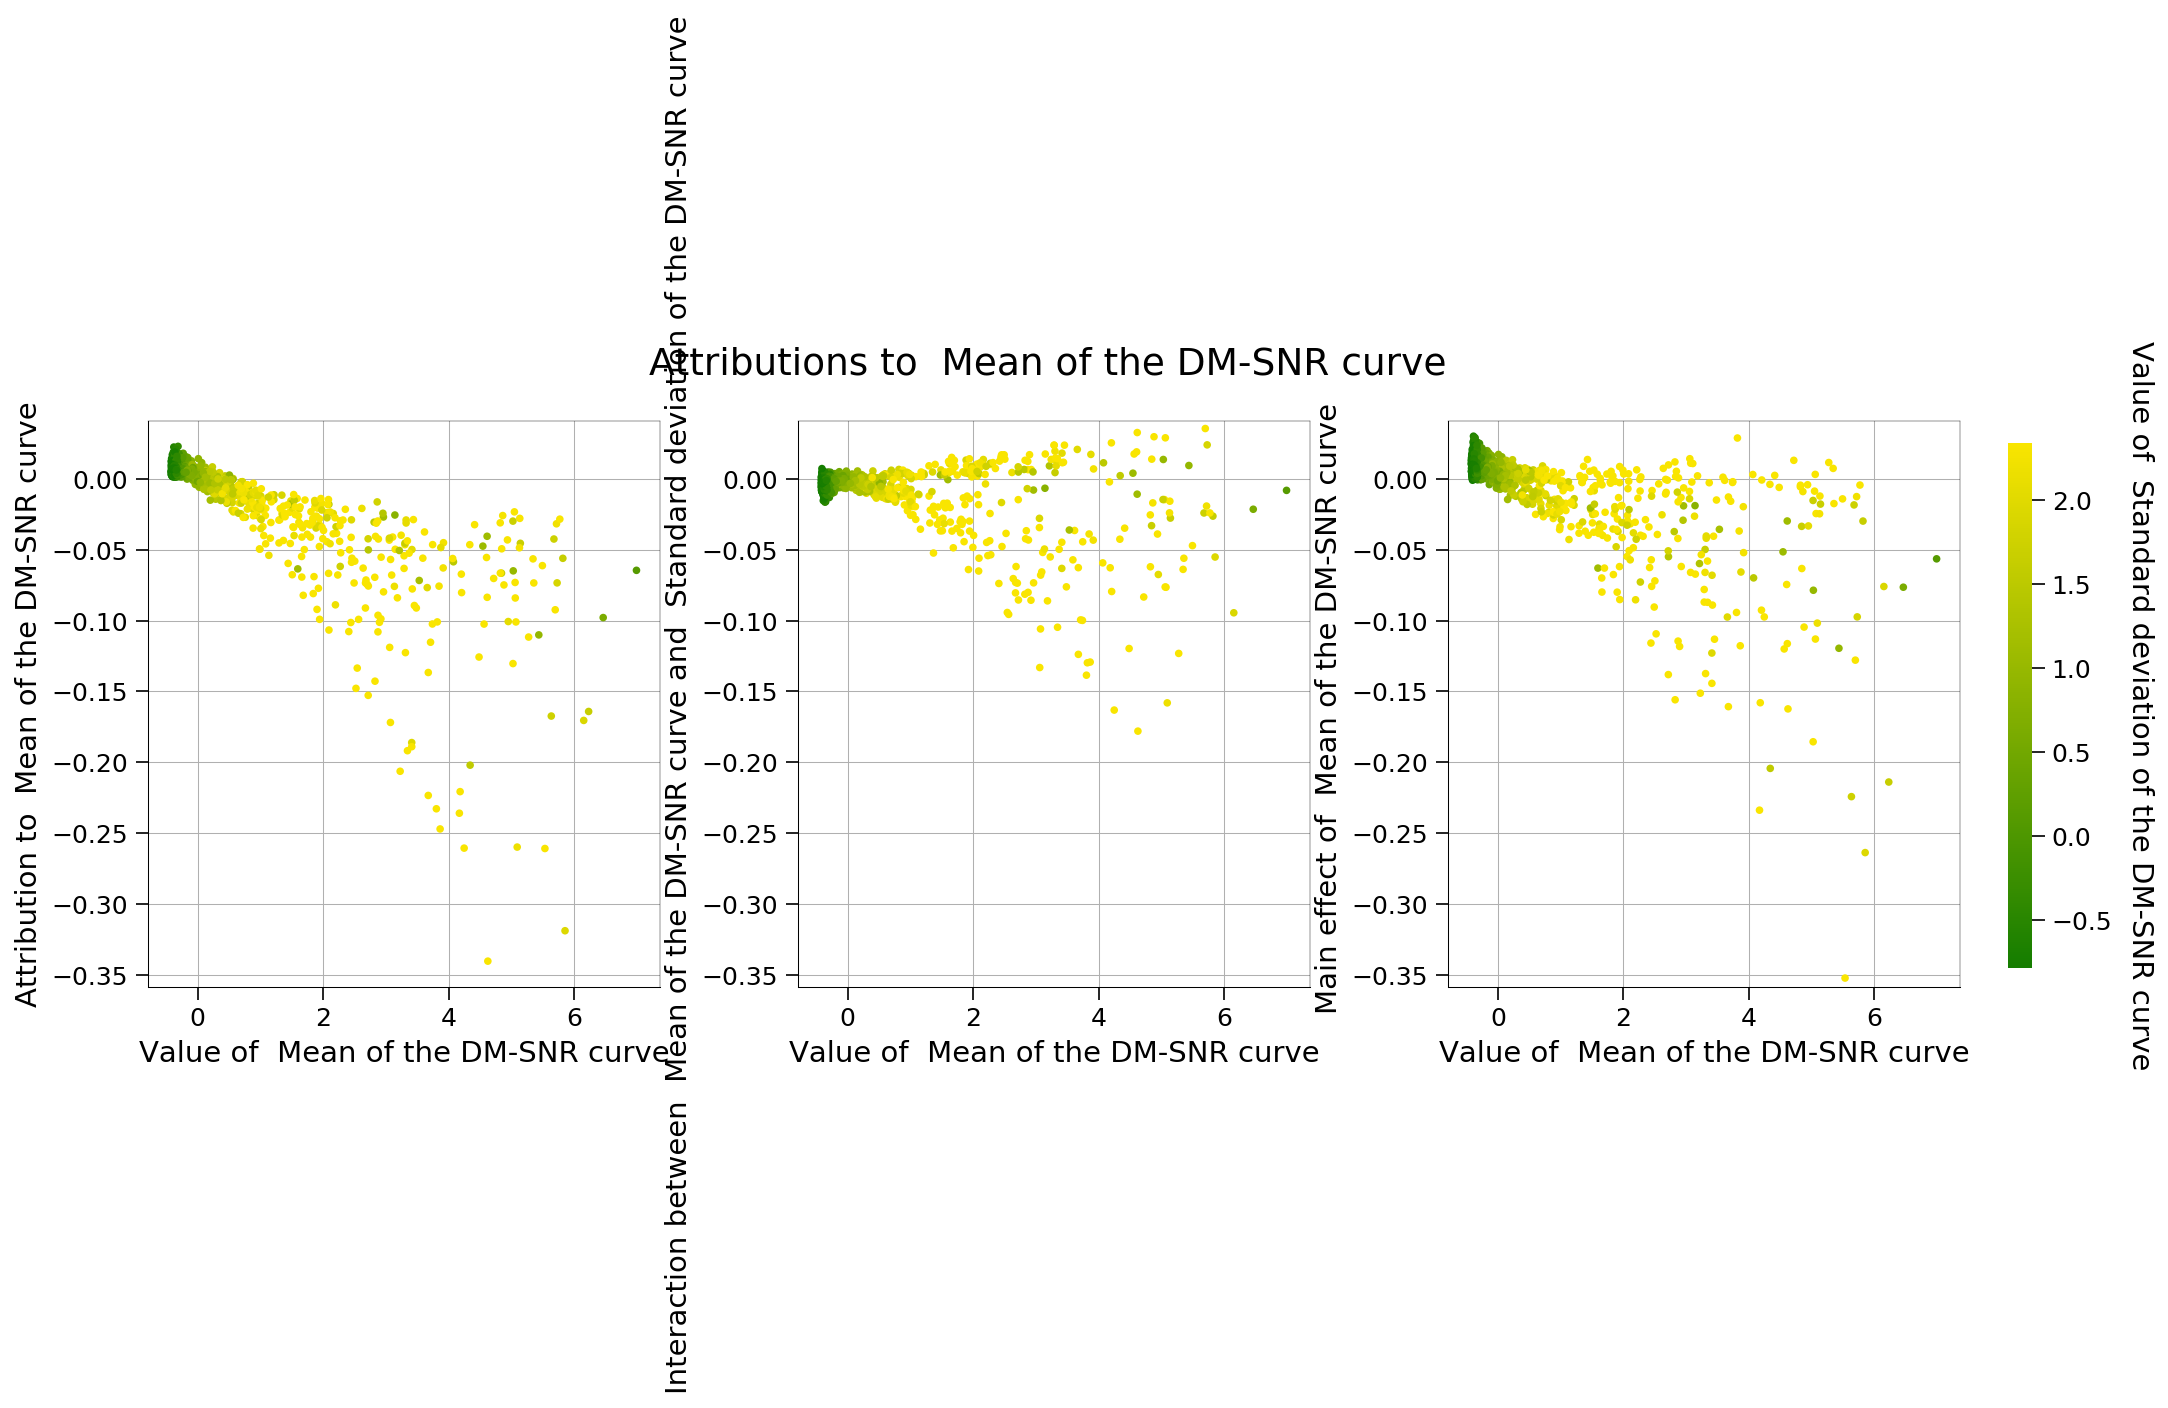

In [16]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index=' Mean of the DM-SNR curve',
                        interactions=interactions,
                        color_by=' Standard deviation of the DM-SNR curve',
                        feature_names=feature_names)